In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)


228813984/228813984 [==============================] - 21s 0us/step


In [6]:
data_dir

WindowsPath('C:/Users/HP/.keras/datasets/flower_photos')

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


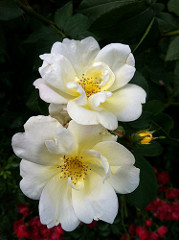

In [11]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

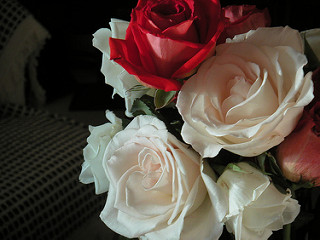

In [12]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [21]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


.cache()는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다
데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
92/92 [==============================] - 19s 204ms/step - loss: 1.2604 - accuracy: 0.4693 - val_loss: 1.1974 - val_accuracy: 0.4918
Epoch 2/30
92/92 [==============================] - 19s 202ms/step - loss: 1.0093 - accuracy: 0.6076 - val_loss: 1.0061 - val_accuracy: 0.5967
Epoch 3/30
92/92 [==============================] - 21s 225ms/step - loss: 0.8164 - accuracy: 0.6975 - val_loss: 0.9680 - val_accuracy: 0.6185
Epoch 4/30
92/92 [==============================] - 22s 240ms/step - loss: 0.6527 - accuracy: 0.7527 - val_loss: 0.9697 - val_accuracy: 0.6403
Epoch 5/30
92/92 [==============================] - 22s 236ms/step - loss: 0.4994 - accuracy: 0.8215 - val_loss: 1.0352 - val_accuracy: 0.6349
Epoch 6/30
92/92 [==============================] - 22s 238ms/step - loss: 0.3321 - accuracy: 0.8852 - val_loss: 1.1817 - val_accuracy: 0.6294
Epoch 7/30
92/92 [==============================] - 22s 238ms/step - loss: 0.2176 - accuracy: 0.9257 - val_loss: 1.3494 - val_accuracy: 0.6172

In [43]:
model.evaluate(val_ds)

23/23 [==============================] - 1s 38ms/step - loss: 2.6381 - accuracy: 0.6063


[2.638054132461548, 0.6062670350074768]

In [27]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [28]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\HP\\.keras\\datasets\\flower_photos\\sunflowers\\8081530919_c882d46bb0_n.jpg'
b'C:\\Users\\HP\\.keras\\datasets\\flower_photos\\dandelion\\4574737576_044403a997_n.jpg'
b'C:\\Users\\HP\\.keras\\datasets\\flower_photos\\roses\\16209331331_343c899d38.jpg'
b'C:\\Users\\HP\\.keras\\datasets\\flower_photos\\tulips\\518256494_368a72db37.jpg'
b'C:\\Users\\HP\\.keras\\datasets\\flower_photos\\sunflowers\\9339697826_88c9c4dc50.jpg'


In [29]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [30]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [31]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [32]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [33]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [34]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [35]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [36]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


In [37]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

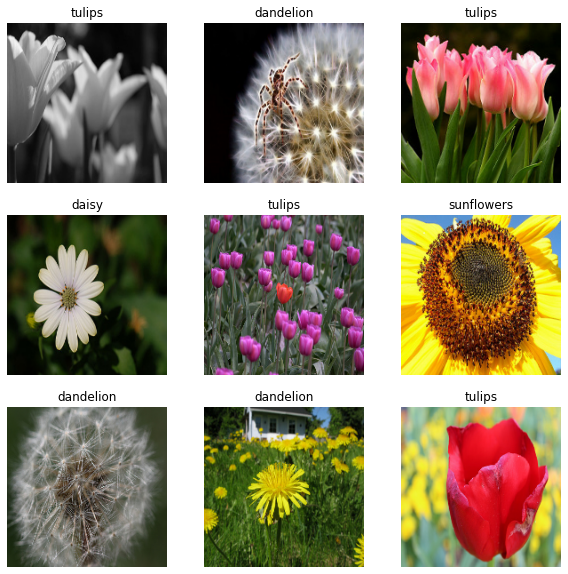

In [38]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [39]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 19s 201ms/step - loss: 0.7771 - accuracy: 0.7033 - val_loss: 0.7770 - val_accuracy: 0.7030
Epoch 2/3
92/92 [==============================] - 20s 214ms/step - loss: 0.6416 - accuracy: 0.7616 - val_loss: 0.8342 - val_accuracy: 0.6676
Epoch 3/3
92/92 [==============================] - 22s 235ms/step - loss: 0.4861 - accuracy: 0.8202 - val_loss: 0.8796 - val_accuracy: 0.6703
